### aim: 

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

CEA1/CEC1/CEC2
CNA1/CNC1/CNC2

### extract qtrB14b and Cflx

In [4]:
extract = False

def make_yearlist(yrst, yrend, dtype, tr, baseDir = '/gpfs/data/greenocean/software/runs/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/TOM12_TJ_{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

def getC14ts(yrst,yrend, tr, dtype = 'diad_T', baseDir = '/gpfs/data/greenocean/software/runs/'):
    
    tdiad = xr.open_mfdataset(make_yearlist(yrst,yrend,'diad_T',tr))
    tdiad.qtrB14b.to_netcdf(f'./GCBdata/{tr}_{yrst}_{yrend}_qtrB14b.nc')
    tdiad.Cflx.to_netcdf(f'./GCBdata/{tr}_{yrst}_{yrend}_Cflx.nc')    
    print(f'{tr} done!')
    
if extract:
    yrst = 1948; yrend = 2019
    
    getC14ts(yrst,yrend, 'CNA1', dtype = 'diad_T', baseDir = '/gpfs/data/greenocean/software/runs/')
    getC14ts(yrst,yrend, 'CNC1', dtype = 'diad_T', baseDir = '/gpfs/data/greenocean/software/runs/')
    getC14ts(yrst,yrend, 'CNC2', dtype = 'diad_T', baseDir = '/gpfs/data/greenocean/software/runs/')
    getC14ts(yrst,yrend, 'CEA1', dtype = 'diad_T', baseDir = '/gpfs/data/greenocean/software/runs/')
    getC14ts(yrst,yrend, 'CEC1', dtype = 'diad_T', baseDir = '/gpfs/data/greenocean/software/runs/')
    getC14ts(yrst,yrend, 'CEC2', dtype = 'diad_T', baseDir = '/gpfs/data/greenocean/software/runs/')


### test effect of year, forcing

864


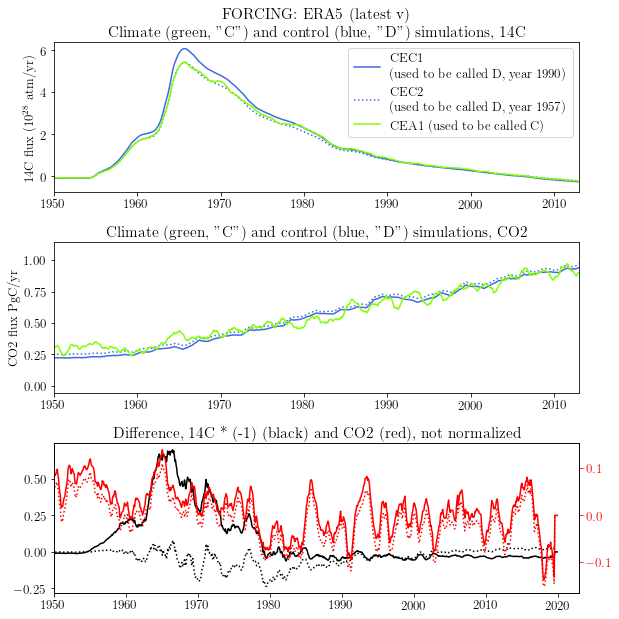

In [5]:
Adir = 'CEA1'
Cdir = 'CEC1'
Cdir2 = 'CEC2'
forc = 'ERA5 (latest v)'
yrst = 1948; yrend = 2019

tmeshf = '/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc'
tmesh = xr.open_dataset(tmeshf)
C14d_qtr_c14 = xr.open_dataset(f'./GCBdata/{Adir}_{yrst}_{yrend}_qtrB14b.nc')   ##static
C14d_Cflx = xr.open_dataset(f'./GCBdata/{Adir}_{yrst}_{yrend}_Cflx.nc') ###static

C14c_qtr_c14 = xr.open_dataset(f'./GCBdata/{Cdir}_{yrst}_{yrend}_qtrB14b.nc')
C14c_Cflx = xr.open_dataset(f'./GCBdata/{Cdir}_{yrst}_{yrend}_Cflx.nc')

C14c2_qtr_c14 = xr.open_dataset(f'./GCBdata/{Cdir2}_{yrst}_{yrend}_qtrB14b.nc')
C14c2_Cflx = xr.open_dataset(f'./GCBdata/{Cdir2}_{yrst}_{yrend}_Cflx.nc')

times = pd.date_range(f'{yrst}/01/01',f'{yrend}/12/31',freq='MS')
print(len(times))

tmeshf = '/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc'
tmesh = xr.open_dataset(tmeshf)

#### -------- B) get areas/grid variables
tmask = tmesh.tmask[0,0,:,:] 
area = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
tarea = np.nansum(area)
vol = area * tmesh.e3t_0[0,0]
tarea2 = np.nansum(vol)/10
# print(tarea)
# print(tarea2)

##### ------ C) "regridding", ie fix the timestamp

qtrnewt_C = C14c_qtr_c14.qtrB14b * tmask.values
cflxnewt_C = C14c_Cflx.Cflx * tmask.values

qtrnewt_C2 = C14c2_qtr_c14.qtrB14b * tmask.values
cflxnewt_C2 = C14c2_Cflx.Cflx * tmask.values

qtrnewt_D = C14d_qtr_c14.qtrB14b * tmask.values
cflxnewt_D = C14d_Cflx.Cflx * tmask.values

qtrnewt_C['time_counter'] = times
qtrnewt_C2['time_counter'] = times
qtrnewt_D['time_counter'] = times

cflxnewt_C['time_counter'] = times
cflxnewt_C2['time_counter'] = times
cflxnewt_D['time_counter'] = times


##### ------ D) fluxes
### QQ why volume/10, why not area, wouldn't it be same?
### QQ why these units?/conversion factors?
qtrflx_C = qtrnewt_C * (1/10) *2 *1e-14 *vol.values * 3.156e7
cflxint_C = cflxnewt_C *area.values*3.156e7 

qtrflx_C2 = qtrnewt_C2 * (1/10) *2 *1e-14 *vol.values * 3.156e7
cflxint_C2 = cflxnewt_C2 *area.values*3.156e7 

qtrflx_D = qtrnewt_D * (1/10) *2 *1e-14 *vol.values * 3.156e7
cflxint_D = cflxnewt_D *area.values*3.156e7 

qtrflx_mn_C = qtrflx_C.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26
qtrflx_mn_C2 = qtrflx_C2.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26
qtrflx_mn_D = qtrflx_D.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26

cflxint_mn_C = cflxint_C.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*12e-15 
cflxint_mn_C2 = cflxint_C2.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*12e-15 
cflxint_mn_D = cflxint_D.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*12e-15 


fact = 1.1
fig, axs = plt.subplots(3,1, figsize=(8*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(qtrflx_C.time_counter, qtrflx_mn_C, color = 'royalblue', label = f'{Cdir} \n (used to be called D, year 1990)')
axs[0].plot(qtrflx_C.time_counter, qtrflx_mn_C2, color = 'royalblue', linestyle = ':', label = f'{Cdir2} \n (used to be called D, year 1957)')

axs[0].plot(qtrflx_C.time_counter, qtrflx_mn_D, color = 'chartreuse', label = f'{Adir} (used to be called C)')
axs[0].legend()

axs[1].plot(qtrflx_C.time_counter, cflxint_mn_C, color = 'royalblue')
axs[1].plot(qtrflx_C.time_counter, cflxint_mn_C2, color = 'royalblue', linestyle = ':',)
axs[1].plot(qtrflx_C.time_counter, cflxint_mn_D, color = 'chartreuse')

ax3 = axs[2]
ax3b = ax3.twinx()
ax3b.tick_params(axis='y', colors='red')
ax3.plot(qtrflx_C.time_counter, (qtrflx_mn_D.values-qtrflx_mn_C.values)*-1, color = 'k')
ax3.plot(qtrflx_C.time_counter, (qtrflx_mn_D.values-qtrflx_mn_C2.values)*-1, color = 'k', linestyle = ':')
ax3b.plot(qtrflx_C.time_counter, cflxint_mn_D.values-cflxint_mn_C.values, color = 'r')
ax3b.plot(qtrflx_C.time_counter, cflxint_mn_D.values-cflxint_mn_C2.values, color = 'r', linestyle = ':')


axs[0].set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
axs[1].set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
ax3.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2023-01-01'))
ax3b.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2023-01-01'))

axs[0].set_title(f'FORCING: {forc} \n Climate (green, "C") and control (blue, "D") simulations, 14C')
axs[1].set_title('Climate (green, "C") and control (blue, "D") simulations, CO2')
axs[2].set_title('Difference, 14C * (-1) (black) and CO2 (red), not normalized')

axs[0].set_ylabel('14C flux ($10^{28}$ atm/yr)')
axs[1].set_ylabel('CO2 flux PgC/yr')


# axs[0].set_ylim([0,7])
# axs[1].set_ylim([0,1.3])
# ax3.set_ylim([-0.4,0.4])
# ax3b.set_ylim([-0.2,0.2])

plt.tight_layout()
plt.show()

864


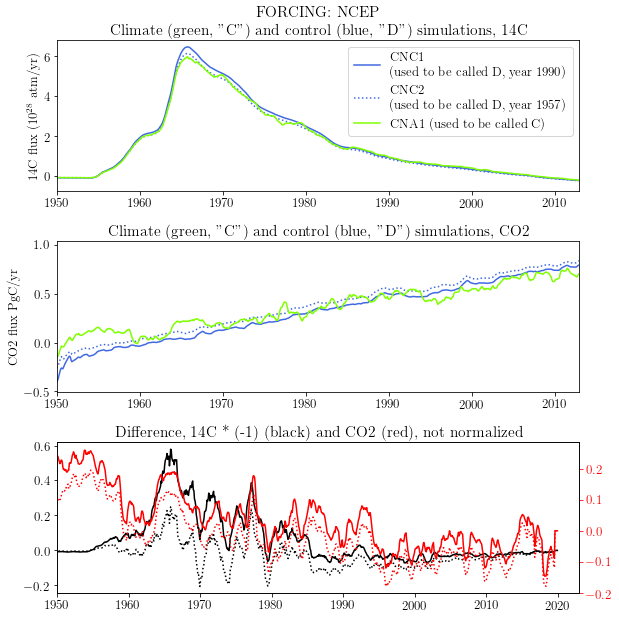

In [6]:
Adir = 'CNA1'
Cdir = 'CNC1'
Cdir2 = 'CNC2'
forc = 'NCEP'

tmeshf = '/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc'
tmesh = xr.open_dataset(tmeshf)
C14d_qtr_c14 = xr.open_dataset(f'./GCBdata/{Adir}_{yrst}_{yrend}_qtrB14b.nc')   ##static
C14d_Cflx = xr.open_dataset(f'./GCBdata/{Adir}_{yrst}_{yrend}_Cflx.nc') ###static

C14c_qtr_c14 = xr.open_dataset(f'./GCBdata/{Cdir}_{yrst}_{yrend}_qtrB14b.nc')
C14c_Cflx = xr.open_dataset(f'./GCBdata/{Cdir}_{yrst}_{yrend}_Cflx.nc')

C14c2_qtr_c14 = xr.open_dataset(f'./GCBdata/{Cdir2}_{yrst}_{yrend}_qtrB14b.nc')
C14c2_Cflx = xr.open_dataset(f'./GCBdata/{Cdir2}_{yrst}_{yrend}_Cflx.nc')

# C14c2_qtr_c14 = xr.open_dataset(f'./GCBdata/{Cdir2}_{yrst}_{yrend}_qtrB14b.nc')
# C14c2_Cflx = xr.open_dataset(f'./GCBdata/{Cdir2}_{yrst}_{yrend}_Cflx.nc')

times = pd.date_range(f'{yrst}/01/01',f'{yrend}/12/31',freq='MS')
print(len(times))

tmeshf = '/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc'
tmesh = xr.open_dataset(tmeshf)

#### -------- B) get areas/grid variables
tmask = tmesh.tmask[0,0,:,:] 
area = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
tarea = np.nansum(area)
vol = area * tmesh.e3t_0[0,0]
tarea2 = np.nansum(vol)/10
# print(tarea)
# print(tarea2)

##### ------ C) "regridding", ie fix the timestamp

qtrnewt_C = C14c_qtr_c14.qtrB14b * tmask.values
cflxnewt_C = C14c_Cflx.Cflx * tmask.values

qtrnewt_C2 = C14c2_qtr_c14.qtrB14b * tmask.values
cflxnewt_C2 = C14c2_Cflx.Cflx * tmask.values

qtrnewt_D = C14d_qtr_c14.qtrB14b * tmask.values
cflxnewt_D = C14d_Cflx.Cflx * tmask.values

qtrnewt_C['time_counter'] = times
qtrnewt_C2['time_counter'] = times
qtrnewt_D['time_counter'] = times

cflxnewt_C['time_counter'] = times
cflxnewt_C2['time_counter'] = times
cflxnewt_D['time_counter'] = times


##### ------ D) fluxes
### QQ why volume/10, why not area, wouldn't it be same?
### QQ why these units?/conversion factors?
qtrflx_C = qtrnewt_C * (1/10) *2 *1e-14 *vol.values * 3.156e7
cflxint_C = cflxnewt_C *area.values*3.156e7 

qtrflx_C2 = qtrnewt_C2 * (1/10) *2 *1e-14 *vol.values * 3.156e7
cflxint_C2 = cflxnewt_C2 *area.values*3.156e7 

qtrflx_D = qtrnewt_D * (1/10) *2 *1e-14 *vol.values * 3.156e7
cflxint_D = cflxnewt_D *area.values*3.156e7 

qtrflx_mn_C = qtrflx_C.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26
qtrflx_mn_C2 = qtrflx_C2.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26
qtrflx_mn_D = qtrflx_D.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26

cflxint_mn_C = cflxint_C.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*12e-15 
cflxint_mn_C2 = cflxint_C2.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*12e-15 
cflxint_mn_D = cflxint_D.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*12e-15 


fact = 1.1
fig, axs = plt.subplots(3,1, figsize=(8*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()




axs[0].plot(qtrflx_C.time_counter, qtrflx_mn_C, color = 'royalblue', label = f'{Cdir} \n (used to be called D, year 1990)')
axs[0].plot(qtrflx_C.time_counter, qtrflx_mn_C2, color = 'royalblue', linestyle = ':', label = f'{Cdir2} \n (used to be called D, year 1957)')

axs[0].plot(qtrflx_C.time_counter, qtrflx_mn_D, color = 'chartreuse', label = f'{Adir} (used to be called C)')
axs[0].legend()

axs[1].plot(qtrflx_C.time_counter, cflxint_mn_C, color = 'royalblue')
axs[1].plot(qtrflx_C.time_counter, cflxint_mn_C2, color = 'royalblue', linestyle = ':',)
axs[1].plot(qtrflx_C.time_counter, cflxint_mn_D, color = 'chartreuse')

ax3 = axs[2]
ax3b = ax3.twinx()
ax3b.tick_params(axis='y', colors='red')
ax3.plot(qtrflx_C.time_counter, (qtrflx_mn_D.values-qtrflx_mn_C.values)*-1, color = 'k')
ax3.plot(qtrflx_C.time_counter, (qtrflx_mn_D.values-qtrflx_mn_C2.values)*-1, color = 'k', linestyle = ':')
ax3b.plot(qtrflx_C.time_counter, cflxint_mn_D.values-cflxint_mn_C.values, color = 'r')
ax3b.plot(qtrflx_C.time_counter, cflxint_mn_D.values-cflxint_mn_C2.values, color = 'r', linestyle = ':')


axs[0].set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
axs[1].set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
ax3.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2023-01-01'))
ax3b.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2023-01-01'))

axs[0].set_title(f'FORCING: {forc} \n Climate (green, "C") and control (blue, "D") simulations, 14C')
axs[1].set_title('Climate (green, "C") and control (blue, "D") simulations, CO2')
axs[2].set_title('Difference, 14C * (-1) (black) and CO2 (red), not normalized')

axs[0].set_ylabel('14C flux ($10^{28}$ atm/yr)')
axs[1].set_ylabel('CO2 flux PgC/yr')


# axs[0].set_ylim([0,7])
# axs[1].set_ylim([0,1.3])
# ax3.set_ylim([-0.4,0.4])
# ax3b.set_ylim([-0.2,0.2])

plt.tight_layout()
plt.show()

### get out graidents, etc

In [7]:

extract = False

if extract:
    
    tmeshf = '/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc'
    tmesh = xr.open_dataset(tmeshf)
    tmask = tmesh.tmask[0,0,:,:] 
    area_surface = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
    area_16 = tmesh.tmask[0,16,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]

    yrst = 1940; yrend = 2024
    tr = 'GEC4'
    trs = ['CNA1','CNC1','CNC2','CEA1','CEC1','CEC2']
    for tr in trs:
        for yr in range(yrst,yrend):

            baseDir = '/gpfs/data/greenocean/software/runs/'
            dtype = 'ptrc'
            ty = f'{baseDir}/TOM12_TJ_{tr}/ORCA2_1m_{yr}*{dtype}*.nc'
            
          
            t2 = glob.glob(ty)
            try:
                w = xr.open_dataset(t2[0])
                ds = [5,10,16,21]
                for d in ds:

                    DIC_L17 = w.DIC.isel(deptht = d).isel(y = slice(0,47)).weighted(area_16.isel(y = slice(0,47))).mean(dim = ['y','x'])
                    DIC_L1 = w.DIC.isel(deptht = 0).isel(y = slice(0,47)).weighted(area_surface.isel(y = slice(0,47))).mean(dim = ['y','x'])
                    DDICDZ = DIC_L17-DIC_L1

                    B14B_L17 = w.B14B.isel(deptht = d).isel(y = slice(0,47)).weighted(area_16.isel(y = slice(0,47))).mean(dim = ['y','x'])
                    B14B_L1 = w.B14B.isel(deptht = 0).isel(y = slice(0,47)).weighted(area_surface.isel(y = slice(0,47))).mean(dim = ['y','x'])
                    DB14DZ = B14B_L17-B14B_L1 

                    C14B_L17 = w.C14B.isel(deptht = d).isel(y = slice(0,47)).weighted(area_16.isel(y = slice(0,47))).mean(dim = ['y','x'])
                    C14B_L1 = w.C14B.isel(deptht = 0).isel(y = slice(0,47)).weighted(area_surface.isel(y = slice(0,47))).mean(dim = ['y','x'])
                    DC14DZ = C14B_L17-C14B_L1 


                    print(f'{tr} {yr}: B14-grad {np.nanmean(DB14DZ)}, C14-grad {np.nanmean(DC14DZ)} DIC-grad {np.nanmean(DDICDZ)}')



                    savenam = f'/gpfs/home/mep22dku/scratch/C14/GCBdata/grad/{tr}_dc14dz_y{yr}_d{d}.nc'
                    data_vars = {'DC14DZ':(['time_counter'], DC14DZ.values,
                    {'units': '',
                    'long_name':f'DC14DZ (lev{d}-lev0, y = slice(0,47), mean, python indexing)'}),

                     'DDICDZ':(['time_counter'], DDICDZ.values,
                    {'units': '',
                    'long_name':f'DDICDZ (lev{d}-lev0, y = slice(0,47), mean, python indexing)'}),            

                    'DB14DZ':(['time_counter'], DB14DZ.values,
                    {'units': '',
                    'long_name':f'DB14DZ (lev{d}-lev0, y = slice(0,47), mean, python indexing)'}),

                    }
                    # define coordinates
                    coords = {'time_counter': (['time_counter'], DC14DZ.time_counter),

                    }
                    # define global attributes
                    attrs = {'made in':'SOZONE/MEDUSA/makeYearlyMEDUSAsubsetfiles.ipynb',
                    'desc': 'yearly medusa files, saving only variables of interest'
                    }
                    ds = xr.Dataset(data_vars=data_vars,
                    coords=coords,
                    attrs=attrs)

                    ds
                    ds.to_netcdf(savenam)

            except:

                print(f'NO FILE MADE FOR {tr} -- {yr}')



### normsig

print('normsig)

In [8]:
## normsig

def make_yearlist(yrst, yrend,rnam,d):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        yr = yrs[i]
        ty = f'/gpfs/home/mep22dku/scratch/C14/GCBdata/grad/{rnam}_dc14dz_y{yr}_d{d}.nc'
        t2 = glob.glob(ty)
        ylist.append(t2[0])
    return ylist

def get_normsig(rnam, d, yrst = 1948, yrend = 2019, normy = 1990):

    C_run = xr.open_mfdataset(make_yearlist(yrst,yrend,rnam,d))
    times = pd.date_range(f"{yrst}/01/01",f"{yrend}/12/31",freq='MS')
    C_run['time_counter'] = times
    tl = (len(times))
    print(tl)
    DC14DZ = np.squeeze(C_run.DC14DZ.values); DC14DZ[np.where(DC14DZ == 0)] = np.nan

    norm = np.squeeze(C_run.DC14DZ.sel(time_counter=slice(f'{normy}-01-01', f'{normy}-12-31')).values)
    repeats = tl // 12
    normt = np.tile(norm, repeats)
    normsig = normt/DC14DZ
    normsig[normsig > 10 ] = np.nan

    return normsig

# yrst = 1948; yrend = 2019; d = 5; normy = 2010
# C_run = xr.open_mfdataset(make_yearlist(yrst,yrend,'CEC1',d))
# DC14DZ = np.squeeze(C_run.DC14DZ.values); DC14DZ[np.where(DC14DZ == 0)] = np.nan
# norm = np.squeeze(C_run.DC14DZ.sel(time_counter=slice(f'{normy}-01-01', f'{normy}-12-31')).values)

# CEA1/CEC1/CEC2
# CNA1/CNC1/CNC2

CEC1_d5norm = get_normsig('CEC1',5)
CEC2_d5norm = get_normsig('CEC2',5)
CNC1_d5norm = get_normsig('CNC1',5)
CNC2_d5norm = get_normsig('CNC2',5)

CEC1_d10norm = get_normsig('CEC1',10)
CEC2_d10norm = get_normsig('CEC2',10)
CNC1_d10norm = get_normsig('CNC1',10)
CNC2_d10norm = get_normsig('CNC2',10)

CEC1_d16norm = get_normsig('CEC1',16)
CEC2_d16norm = get_normsig('CEC2',16)
CNC1_d16norm = get_normsig('CNC1',16)
CNC2_d16norm = get_normsig('CNC2',16)

CEC1_d21norm = get_normsig('CEC1',21)
CEC2_d21norm = get_normsig('CEC2',21)
CNC1_d21norm = get_normsig('CNC1',21)
CNC2_d21norm = get_normsig('CNC2',21)


#C_run = xr.open_mfdataset(make_yearlist(yrst,yrend,rnam,d))

864
864
864
864
864
864
864
864
864
864
864
864
864
864
864
864


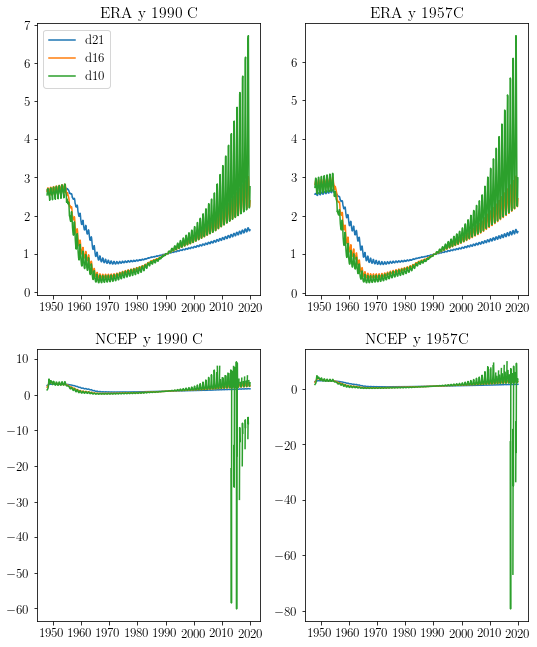

In [9]:
yrst = 1948; yrend = 2019; d = 5; normy = 2010
C_run = xr.open_mfdataset(make_yearlist(yrst,yrend,'CEC1',d))
times = pd.date_range(f"{yrst}/01/01",f"{yrend}/12/31",freq='MS')
C_run['time_counter'] = times

# plt.figure()
# plt.plot(times,CNC2_d21norm, label = ')

fact = 1.1
fig, axs = plt.subplots(2,2, figsize=(8*fact, 10*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

ind = 0
axs[ind].plot(times,CEC1_d21norm, label = 'd21')
axs[ind].plot(times,CEC1_d16norm, label = 'd16')
axs[ind].plot(times,CEC1_d10norm, label = 'd10')
axs[0].legend(loc = 'best')

ind = 1
axs[ind].plot(times,CEC2_d21norm)
axs[ind].plot(times,CEC2_d16norm) 
axs[ind].plot(times,CEC2_d10norm) 

ind = 2
axs[ind].plot(times,CNC1_d21norm, label = 'd21')
axs[ind].plot(times,CNC1_d16norm, label = 'd16')
axs[ind].plot(times,CNC1_d10norm, label = 'd10')
axs[0].legend(loc = 'best')

ind = 3
axs[ind].plot(times,CNC2_d21norm)
axs[ind].plot(times,CNC2_d16norm) 
axs[ind].plot(times,CNC2_d10norm) 

tits = ['ERA y 1990 C', 'ERA y 1957C', 'NCEP y 1990 C', 'NCEP y 1957C',]
for i in range(0,4):
    
    axs[i].set_title(tits[i])

## plot gradient

In [10]:
# CactuallyAs = 
# DactuallyCs = 


def plot_c14_sig(Adir, Cdir, forc, d5norm, d10norm, d16norm, d21norm, \
                 dyrst = 1948, yrend =2019, stcor = 1955, ecor = 2015):
    
    plotdat = False

    #load data
    tmeshf = '/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc'
    tmesh = xr.open_dataset(tmeshf)
    C14d_qtr_c14 = xr.open_dataset(f'./GCBdata/{Adir}_{yrst}_{yrend}_qtrB14b.nc')   ##static
    C14d_Cflx = xr.open_dataset(f'./GCBdata/{Adir}_{yrst}_{yrend}_Cflx.nc') ###static

    C14c_qtr_c14 = xr.open_dataset(f'./GCBdata/{Cdir}_{yrst}_{yrend}_qtrB14b.nc')
    C14c_Cflx = xr.open_dataset(f'./GCBdata/{Cdir}_{yrst}_{yrend}_Cflx.nc')

    #do recalculations 
    tmeshf = '/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc'
    tmesh = xr.open_dataset(tmeshf)
    C14d_qtr_c14 = xr.open_dataset(f'./GCBdata/{Adir}_{yrst}_{yrend}_qtrB14b.nc')   ##static
    C14d_Cflx = xr.open_dataset(f'./GCBdata/{Adir}_{yrst}_{yrend}_Cflx.nc') ###static

    C14c_qtr_c14 = xr.open_dataset(f'./GCBdata/{Cdir}_{yrst}_{yrend}_qtrB14b.nc')
    C14c_Cflx = xr.open_dataset(f'./GCBdata/{Cdir}_{yrst}_{yrend}_Cflx.nc')

    C14c2_qtr_c14 = xr.open_dataset(f'./GCBdata/{Cdir2}_{yrst}_{yrend}_qtrB14b.nc')
    C14c2_Cflx = xr.open_dataset(f'./GCBdata/{Cdir2}_{yrst}_{yrend}_Cflx.nc')

    # C14c2_qtr_c14 = xr.open_dataset(f'./GCBdata/{Cdir2}_{yrst}_{yrend}_qtrB14b.nc')
    # C14c2_Cflx = xr.open_dataset(f'./GCBdata/{Cdir2}_{yrst}_{yrend}_Cflx.nc')

    times = pd.date_range(f'{yrst}/01/01',f'{yrend}/12/31',freq='MS')
    print(len(times))

    tmeshf = '/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc'
    tmesh = xr.open_dataset(tmeshf)

    #### -------- B) get areas/grid variables
    tmask = tmesh.tmask[0,0,:,:] 
    area = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
    tarea = np.nansum(area)
    vol = area * tmesh.e3t_0[0,0]
    tarea2 = np.nansum(vol)/10
    # print(tarea)
    # print(tarea2)

    ##### ------ C) "regridding", ie fix the timestamp

    qtrnewt_C = C14c_qtr_c14.qtrB14b * tmask.values
    cflxnewt_C = C14c_Cflx.Cflx * tmask.values

    qtrnewt_C2 = C14c2_qtr_c14.qtrB14b * tmask.values
    cflxnewt_C2 = C14c2_Cflx.Cflx * tmask.values

    qtrnewt_D = C14d_qtr_c14.qtrB14b * tmask.values
    cflxnewt_D = C14d_Cflx.Cflx * tmask.values

    qtrnewt_C['time_counter'] = times
    qtrnewt_C2['time_counter'] = times
    qtrnewt_D['time_counter'] = times

    cflxnewt_C['time_counter'] = times
    cflxnewt_C2['time_counter'] = times
    cflxnewt_D['time_counter'] = times


    ##### ------ D) fluxes
    ### QQ why volume/10, why not area, wouldn't it be same?
    ### QQ why these units?/conversion factors?
    qtrflx_C = qtrnewt_C * (1/10) *2 *1e-14 *vol.values * 3.156e7
    cflxint_C = cflxnewt_C *area.values*3.156e7 

    qtrflx_D = qtrnewt_D * (1/10) *2 *1e-14 *vol.values * 3.156e7
    cflxint_D = cflxnewt_D *area.values*3.156e7 

    qtrflx_mn_C = qtrflx_C.rolling(time_counter=12, center=True).mean()\
    .sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26
    qtrflx_mn_C2 = qtrflx_C2.rolling(time_counter=12, center=True).mean()\
    .sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26
    qtrflx_mn_D = qtrflx_D.rolling(time_counter=12, center=True).mean()\
    .sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26

    cflxint_mn_C = cflxint_C.rolling(time_counter=12, center=True).mean()\
    .sel(y=slice(0,47)).sum(dim = ['x','y'])*12e-15 
    cflxint_mn_D = cflxint_D.rolling(time_counter=12, center=True).mean()\
    .sel(y=slice(0,47)).sum(dim = ['x','y'])*12e-15 


    fact = 1.1
    fig, axs = plt.subplots(4,1, figsize=(8*fact, 10*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    ax3 = axs[2]
    ax3b = ax3.twinx()
    ax3b.tick_params(axis='y', colors='red')

    ax4 = axs[3]
    ax4b = ax4.twinx()
    ax4b.tick_params(axis='y', colors='red')

    if plotdat:


        axs[0].plot(qtrflx_C.time_counter, qtrflx_mn_C, color = 'royalblue', label = f'{Cdir} \n (used to be called D, year 1990)')
        axs[0].plot(qtrflx_C.time_counter, qtrflx_mn_D, color = 'chartreuse', label = f'{Adir} (used to be called C)')
        axs[0].legend()

        axs[1].plot(qtrflx_C.time_counter, cflxint_mn_C, color = 'royalblue')
        axs[1].plot(qtrflx_C.time_counter, cflxint_mn_D, color = 'chartreuse')

        ax3.plot(qtrflx_C.time_counter, (qtrflx_mn_D.values-qtrflx_mn_C.values)*-1, color = 'k')
        ax3b.plot(qtrflx_C.time_counter, cflxint_mn_D.values-cflxint_mn_C.values, color = 'r')

        #ax4.plot(qtrflx_C.time_counter, (qtrflx_mn_D.values-qtrflx_mn_C.values)*-1*d5norm, color = 'k', label = 'dl 5 ')
        ax4.plot(qtrflx_C.time_counter, (qtrflx_mn_D.values-qtrflx_mn_C.values)*-1*d10norm, color = 'y', label = 'dl 10')
        ax4.plot(qtrflx_C.time_counter, (qtrflx_mn_D.values-qtrflx_mn_C.values)*-1*d16norm, color = 'b', label = 'dl 16 (original)')
        ax4.plot(qtrflx_C.time_counter, (qtrflx_mn_D.values-qtrflx_mn_C.values)*-1*d21norm, color = 'g', label = 'dl 21')
        ax4b.plot(qtrflx_C.time_counter, (cflxint_mn_D.values-cflxint_mn_C.values), color = 'r')

    for i in range(0,4):
        axs[i].set_xlim(pd.Timestamp('1948-01-01'), pd.Timestamp('2013-01-01'))
        
    ax3b.set_xlim(pd.Timestamp('1948-01-01'), pd.Timestamp('2013-01-01'))
    ax4b.set_xlim(pd.Timestamp('1948-01-01'), pd.Timestamp('2013-01-01'))

    axs[0].set_title(f'FORCING: {forc} \n Climate (green, "C") and control (blue, "D") simulations, 14C')
    axs[1].set_title('Climate (green, "C") and control (blue, "D") simulations, CO2')
    axs[2].set_title('Difference, 14C * (-1) (black) and CO2 (red), not normalized')
    axs[3].set_title('Difference, 14C * (-1) (black) and CO2 (red), normalized')
    axs[0].set_ylabel('14C flux ($10^{28}$ atm/yr)')
    axs[1].set_ylabel('CO2 flux PgC/yr')


    ##calculate correlations 


    ytr = stcor - yrst
    yoc = ecor - stcor
    soy = 12*ytr #remove first 16 years, start at 1956

    from scipy.stats import pearsonr

    nval = [5,10,16,21]
    norms = [d5norm, d10norm, d16norm, d21norm]
    rs = np.zeros([4])
    ps = np.zeros([4])

    if plotdat:
        for i in range(0,4):
            flxdiff = cflxint_mn_D.values-cflxint_mn_C.values
            c14diff = (qtrflx_mn_D.values-qtrflx_mn_C.values)*-1*norms[i]

            # Example data 
            x = flxdiff[soy:soy+yoc*12]  # Replace with your actual data
            y = c14diff[soy:soy+yoc*12]
            r_value, p_value = pearsonr(x, y)
            print(f'normalized at {nval[i]}, r: {r_value} p: {p_value}')  # Replace with your actual data
            rs[i] = r_value; ps[i] = p_value

    return rs, ps

In [ ]:
# CEC1_d5norm = get_normsig('CEC1',5)
# CEC2_d5norm = get_normsig('CEC2',5)
# CNC1_d5norm = get_normsig('CNC1',5)
# CNC2_d5norm = get_normsig('CNC2',5)

rs, ps = plot_c14_sig('CEA1', 'CEC1', 'ERA', CEC1_d5norm, CEC1_d10norm, CEC1_d16norm, CEC1_d21norm, \
                 dyrst = 1948, yrend =2019, stcor = 1955, ecor = 2015)
    
    

864


In [ ]:
CactuallyAs = 
DactuallyCs = 